<p><h1>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;PUC MINAS - Pontifícia Universidade Católica de Minas Gerais</h1></p>

<p><h2>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pós Graduação em Inteligência Artificial E Aprendizado de Máquina</h2></p>

<p><h3>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Trabalho de Conclusão de Curso</h3></p>

<h4>Título: Análise de Séries Temporais sobre a Ação do Bitcoin</h4>

<h4>Aluno: Renan Nunes Bittencourt</h4>

<h7>Venho através deste trabalho apresentar os modelos preditivos utilizados na análise da regressão de uma série temporal na ação do Bitcoin. Este notebook visa a predição dos valores de fechamento diário das ações durante um período de 30 dias.Neste trabalho foi utilizado o Dataset do Kaggle de “Analyzing and Predicting Bitcoin pricing trend” onde pode ser adquirido através deste link (<a href="https://www.kaggle.com/datasets/surajjha101/analyzing-and-prediction-of-bitcoin-pricing">Clique Aqui</a>).</h7>

#### Importações das Bibliotecas

In [70]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
# Manipulação dos Dados
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Processamento
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Modelos de Aprendizagem
#import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from prophet import Prophet
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

# Métricas de erro
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

In [72]:
with open ('BTC-USD_saved.pkl', 'rb') as f:
  df = pickle.load(f)

In [73]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Risk,Return
Date,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2014,9,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2014,9,NaN,-0.071926
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2014,9,NaN,-0.069843
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,2014,9,NaN,0.035735
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,2014,9,NaN,-0.024659


Acima puxamos os últimos dados gerados no primeiro notebook e imprimimos suas linhas iniciais para constatação da confiabilidade dos dados.

#### Preparação dos Dados

In [74]:
# Atribuindo a coluna de previsão (Close) para a váriavel de predição y
target = df['Close']
target.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

Aqui incluímos a coluna alvo a nossa variável target

In [75]:
len(target)

2788

Podemos ver quantas linhas sobraram após a retirada das linhas nulas

In [76]:
validation = target.tail(30)
len(validation)

30

Acima efetuamos a retirada das últimas 30 linha que poderemos verificar a qualidade do nosso modelo final

In [77]:
y = target.head(len(df) - len(validation))
len(y)

2758

Notamos quantas linhas sobraram após a retirada do intervalo para validação

In [78]:
# Verificando o numero de linhas a serem utilizadas
treino_linhas = int((90 * len(y)) / 100)
teste_linhas = treino_linhas + 1

treino_linhas, teste_linhas, len(y)

(2482, 2483, 2758)

Acima separamos o número de linhas que servirá como nosso intervalo de treinamento e teste

In [79]:
# Separando o Dataframe entre treino e teste da features dependentes
treino_y = y.head(treino_linhas)

test_y = y[treino_linhas:]


print(f'Data mínima da treino: {treino_y.index.min()}\nData máxima da treino: {treino_y.index.max()}\nNúmero de linhas de treino: {len(treino_y)}')

Data mínima da treino: 2014-09-17 00:00:00
Data máxima da treino: 2021-07-03 00:00:00
Número de linhas de treino: 2482


In [80]:
print(f'Data mínima da teste: {test_y.index.min()}\nData máxima da teste: {test_y.index.max()}\nNúmero de linhas de teste: {len(test_y)}')

Data mínima da teste: 2021-07-04 00:00:00
Data máxima da teste: 2022-04-05 00:00:00
Número de linhas de teste: 276


Nas três células acima podemos ver em que data e valor termina o conjunto de dados de treinamento e onde começa o conjunto de dados de teste.

A última célula podemos ver onde termina nosso conjunto de dados de teste, significa que os próximos 30 dias serão nossos dados de validação.

In [81]:
print(f'Data mínima da validação: {validation.index.min()}\nData máxima da validação: {validation.index.max()}\nNúmero de linhas de validação: {len(validation)}')

Data mínima da validação: 2022-04-06 00:00:00
Data máxima da validação: 2022-05-05 00:00:00
Número de linhas de validação: 30


E acima confirmamos a data e valores que iniciam nosso conjunto de validação

In [82]:
len(validation) + len(test_y) + len(treino_y), len(df)

(2788, 2788)

Nesta célula conferimos se a união dos dados de treinamento mais os dados de teste bate com o valor total do conjunto de dados sem a validação

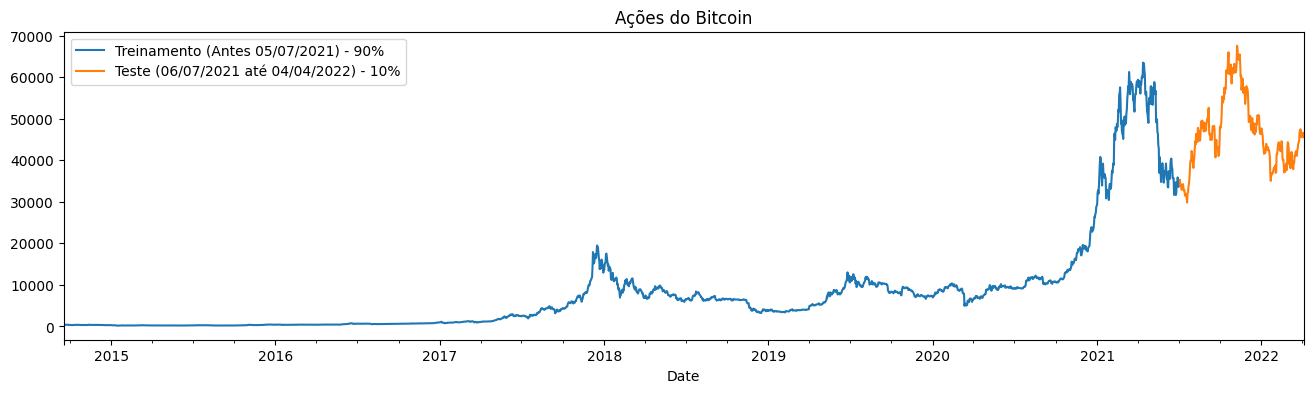

In [83]:
# Plotando treino e teste
treino_y.plot(figsize=(16,4),legend=True)
test_y.plot(figsize=(16,4),legend=True)
plt.legend(['Treinamento (Antes 05/07/2021) - 90%','Teste (06/07/2021 até 04/04/2022) - 10%'])
plt.title('Ações do Bitcoin')
#plt.grid(True)
plt.show()

E aqui podemos ter uma visão gráfica temporal de como os dados foram distribuídos, escolhemos esta porcentagem de treinamento e teste levando em consideração que temos poucos dados para esta análise de série temporal. Ficando 90% para treinamento e 10% para teste.

#### Modelo Auto Arima

##### Preparação dos dados

In [84]:
y_diff = np.diff(treino_y)

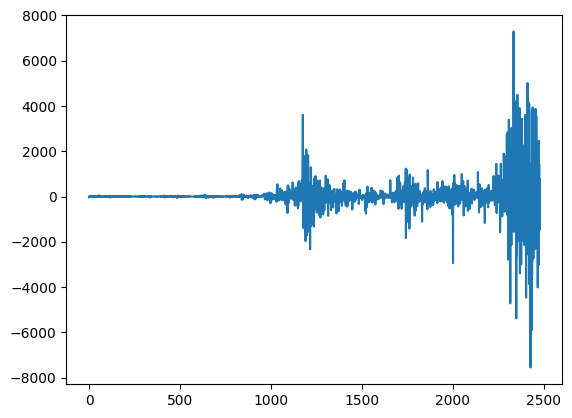

In [85]:
plt.plot(y_diff);

In [86]:
# Teste de ADF
diff1 = adfuller(y_diff)
print(f'P-value: {diff1[1]}')

P-value: 4.095046451290537e-12


Conforme verificado na fase de "Entendimento dos dados", nosso teste de Dick Fuller apresentou resultado acima de 0.05, então efetuamos uma diferenciação e executamos novamente o teste para verificar se agora os nossos p-valor está inferior a 0.05, e conforme constatado agora temos valores da estacionários

##### Modelo

In [87]:
model_arima = auto_arima(y_diff, start_p=1, start_q=1, max_p=20, max_q=20, m=0, start_P=0, seasonal=False, d=1, D=1, 
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41013.943, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40055.190, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41011.944, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39744.946, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39586.220, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=39518.286, Time=0.91 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39424.904, Time=1.13 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=39401.983, Time=1.28 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=39399.802, Time=2.39 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=39346.175, Time=3.03 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=39258.411, Time=3.56 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=39203.490, Time=3.78 sec
 ARIMA(11,1,0)(0,0,0)[0] inter

Efetuamos a procura do melhor modelo Arima com o auto arima e obtivemos o melhor modelo “ARIMA(12,1,0)” onde o "p" é a ordem da parte autoregressiva (lags), o "d" é o grau de diferenciação e o "q" é a diferenciação que trata da ordem da média móvel. Podemos perceber também que temos uma sequência final de 4 zeros "(0,0,0)[0]", onde indica que não possuímos uma tendência de sazonalidade.

In [88]:
# Treinando o modelo com os ddos de treino
model_fit = model_arima.fit(treino_y)
model_fit

ARIMA(order=(12, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [89]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2482
Model:              SARIMAX(12, 1, 0)   Log Likelihood              -19492.718
Date:                Tue, 30 May 2023   AIC                          39011.436
Time:                        22:22:54   BIC                          39087.050
Sample:                    09-17-2014   HQIC                         39038.898
                         - 07-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.008     -8.302      0.000      -0.081      -0.050
ar.L2          0.0921      0.008     11.709      0.000       0.077       0.108
ar.L3          0.0531      0.008      6.720      0.0

Podemos perceber algumas estatísticas:

AIC_ está com um valor muito alto, significa que o nosso modelo está perdendo muita informação

BIC_ está com um valor muito alto, também significa que o modelo está sendo mais penalizado pela perda de informação

Ljung box_ mostra um resultado de 0 abaixo de 0.05, indicando que os resíduos não são distribuídos independentemente

Heterocedasticidade_ podemos ver o grau do de variância do nosso modelo que não é constante

Podemos também perceber no quadro que não possuímos médias móveis, ele demonstra 12 lags para 12 dias atrás.


In [90]:
# Prevendo valores
predict_sarimax = model_fit.predict(n_periods=len(test_y))
future_sarimax = pd.DataFrame(predict_sarimax, index=test_y.index, columns=['Prediction_Arima'])

# Intervalo de confiança
intervalo = model_fit.predict(len(test_y), return_conf_int=True, alpha=0.05)

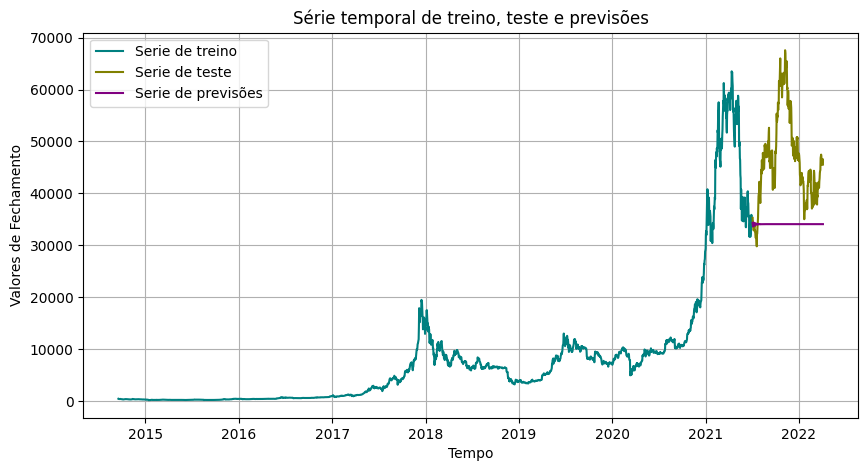

In [91]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de treino, teste e previsões')
plt.plot(treino_y, color='teal', label='Serie de treino')
plt.plot(test_y, color='olive', label='Serie de teste')
plt.plot(future_sarimax['Prediction_Arima'], color='purple', label='Serie de previsões')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Podemos perceber que o modelo acompanhou uma tendência de estacionaridade, mas não teve uma predição tão significativa

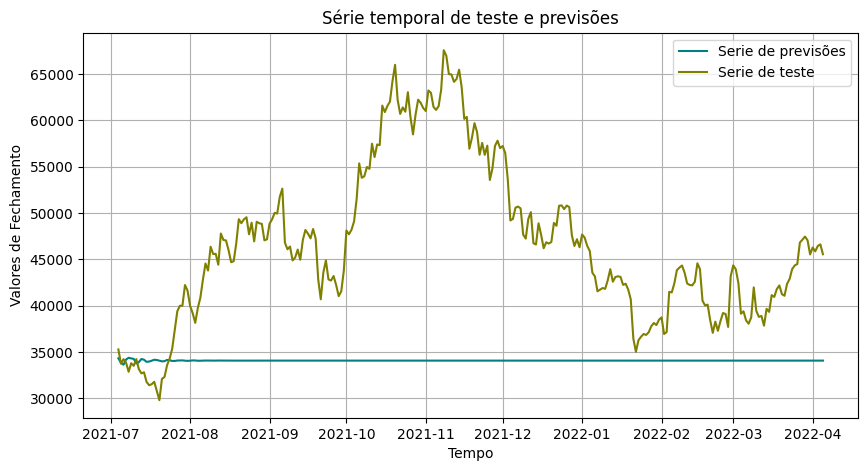

In [92]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de teste e previsões')
plt.plot(future_sarimax['Prediction_Arima'], color='teal', label='Serie de previsões')
plt.plot(test_y, color='olive', label='Serie de teste')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Aqui temos uma visão mais aproximada dos valores de teste e os valores de predição, onde podemos perceber que temos valores de teste que nem conseguiram ficar na zona do intervalo de confiança

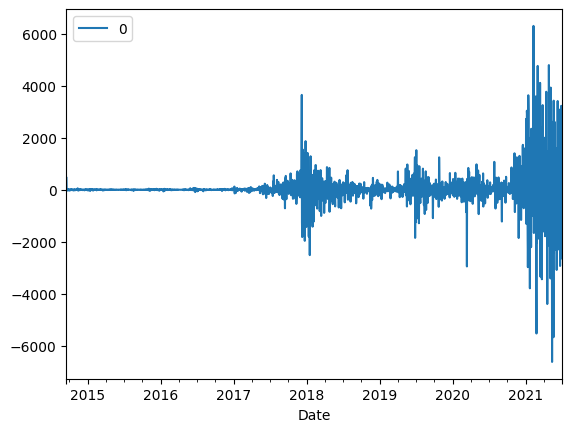

In [93]:
residual = pd.DataFrame(model_fit.resid())
residual.plot();

Podemos perceber temos um ruído branco onde não encontramos nenhuma tendência ou sazonalidade

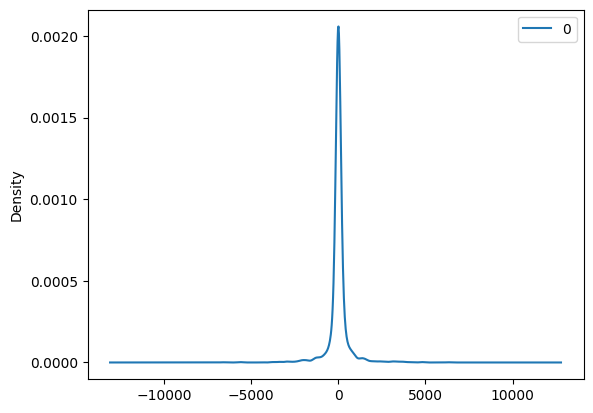

                 0
count  2482.000000
mean     12.496626
std     624.939067
min   -6631.111618
25%     -35.939139
50%       1.411772
75%      57.307271
max    6310.669969


In [94]:
residual.plot(kind='kde')
plt.show()
print(residual.describe())

Podemos perceber que através de algumas métricas onde são levadas em consideração os valores de erros do algoritmo, temos valores muito altos, sendo possível constatar a comparação gráfica da predição com os valores reais, sendo que este modelo não obteve um bom desempenho com somente a previsão de um dia

##### Métricas de erro

In [95]:
print(f'MAE: {mean_absolute_error(test_y, future_sarimax):.5f}')
print(f'RMSE: {mean_squared_error(test_y, future_sarimax, squared=False):.5f}')
print(f'R2_SCORE: {r2_score(test_y, future_sarimax):.5f}')

MAE: 12680.82154
RMSE: 15089.45326
R2_SCORE: -2.16073


Podemos perceber que atraves de algumas métricas onde são levandas em consideração os valores de erros do algoritmo, temos valores muito altos, sendo possive constatar a comparação gráfica da prediçãao com os valores reais, sendo que este modelo não obteve uma boa performance com somente a previsão de um dia

#### Modelo Facebook Prophet

##### Preparação dos dados

In [96]:
df_ri = treino_y.reset_index()
df_ri

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
2477,2021-06-29,35867.777344
2478,2021-06-30,35040.835938
2479,2021-07-01,33572.117188
2480,2021-07-02,33897.046875


Acima retiramos a coluna de data da indexação e retornamos a mesma como uma coluna.

In [97]:
df_prophet = df_ri[['Date', 'Close']].rename(columns = {'Date':'ds','Close':'y'})
df_prophet

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
2477,2021-06-29,35867.777344
2478,2021-06-30,35040.835938
2479,2021-07-01,33572.117188
2480,2021-07-02,33897.046875


Renomeamos o nosso atributo alvo como "y" e o atributo data da comercialização para "ds", conforme orientação da documentação do modelo.

##### Modelo

In [98]:
modelo = Prophet()
modelo.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4olzvvo7/6izs7dce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4olzvvo7/o0q2w8yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49510', 'data', 'file=/tmp/tmp4olzvvo7/6izs7dce.json', 'init=/tmp/tmp4olzvvo7/o0q2w8yz.json', 'output', 'file=/tmp/tmp4olzvvo7/prophet_model7_ho45x4/prophet_model-20230530222255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Efetuamos o treinamento sem nenhum parâmetro adicional.

In [99]:
futuro = modelo.make_future_dataframe(periods=len(test_y))
previsoes = modelo.predict(futuro)

Acima criamos uma variável onde ele irá gerar uma dataframe com as previsões futuras no "make_future_dataframe" com o período sendo o mesmo numero dias da base de teste. 

Após criarmos este dataframe, passamos o mesmo para o "predict" do modelo executar as previsões.

In [100]:
previsoes.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-17,462.313423,-6925.851808,4037.474950,462.313423,462.313423,-1967.616449,-1967.616449,-1967.616449,7.620424,7.620424,7.620424,-1975.236873,-1975.236873,-1975.236873,0.0,0.0,0.0,-1505.303026
1,2014-09-18,460.719353,-7269.325345,3599.160053,460.719353,460.719353,-1978.665641,-1978.665641,-1978.665641,-6.496454,-6.496454,-6.496454,-1972.169187,-1972.169187,-1972.169187,0.0,0.0,0.0,-1517.946288
2,2014-09-19,459.125283,-6978.856171,3908.120925,459.125283,459.125283,-1974.881341,-1974.881341,-1974.881341,-6.312865,-6.312865,-6.312865,-1968.568476,-1968.568476,-1968.568476,0.0,0.0,0.0,-1515.756058
3,2014-09-20,457.531213,-7247.841418,3831.137162,457.531213,457.531213,-1967.193344,-1967.193344,-1967.193344,-2.066572,-2.066572,-2.066572,-1965.126772,-1965.126772,-1965.126772,0.0,0.0,0.0,-1509.662131
4,2014-09-21,455.937143,-7168.604370,3726.076473,455.937143,455.937143,-1967.912698,-1967.912698,-1967.912698,-5.419491,-5.419491,-5.419491,-1962.493207,-1962.493207,-1962.493207,0.0,0.0,0.0,-1511.975555


Podemos perceber neste dataframe gerado que temos dados deste a data inicial da base de treinamento, pois ele começa a prever do início da base e posterior o período solicitado.

Neste novo dataframe temos alguns atributos:


*   Trend_ tendencia
*   yhat_lower_ valor mínimo
*   yhat_upper_ valor máximo
*   additive_terms_ onde o algoritmo utiliza regressão aditiva
*   weekly_ são predições semanais
*   yearly_ predições anuais
*   yhat_ são os nossos valores de predição










In [101]:
df_prev_prophet = previsoes.set_index('ds')
df_prev_prophet = df_prev_prophet[['yhat','yhat_lower','yhat_upper']]

Acima retornamos a coluna de data como indexadora e pegamos somente os dados importantes para plotarmos os gráficos de previsão como os valores previstos e os valores máximos e mínimos do intervalo de confiança.

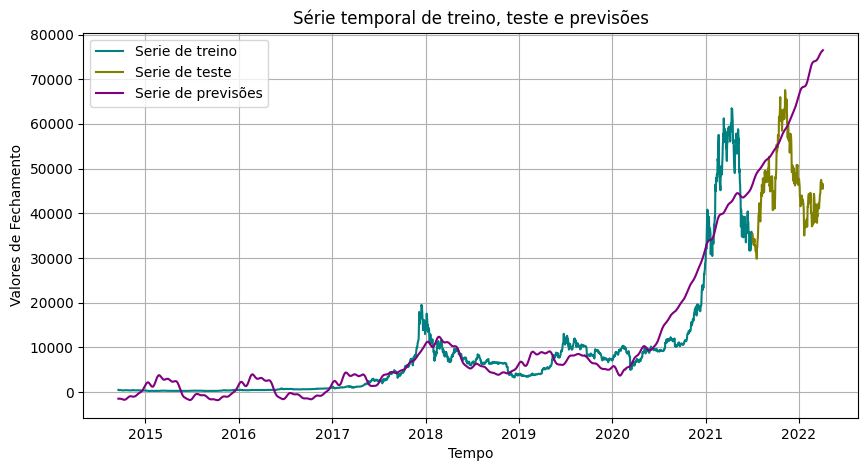

In [102]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de treino, teste e previsões')
plt.plot(treino_y, color='teal', label='Serie de treino')
plt.plot(test_y, color='olive', label='Serie de teste')
#plt.fill_between(y.index, df_prev_prophet['yhat_lower'], df_prev_prophet['yhat_upper'], color='k', alpha=0.08)
plt.plot(df_prev_prophet['yhat'], color='purple', label='Serie de previsões')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Podemos notar que as previsões feitas pelo modelo com as datas da base de treinamento se ajustam bem aos valores reais, deixando a maioria dos valores reais dentro do intervalo de confiança do modelo.

Mas a partir do ano de 2020, ele começa a se perder não conseguindo identificar um padrão nos dados, onde que nos dados de testes temos grandes perdas.

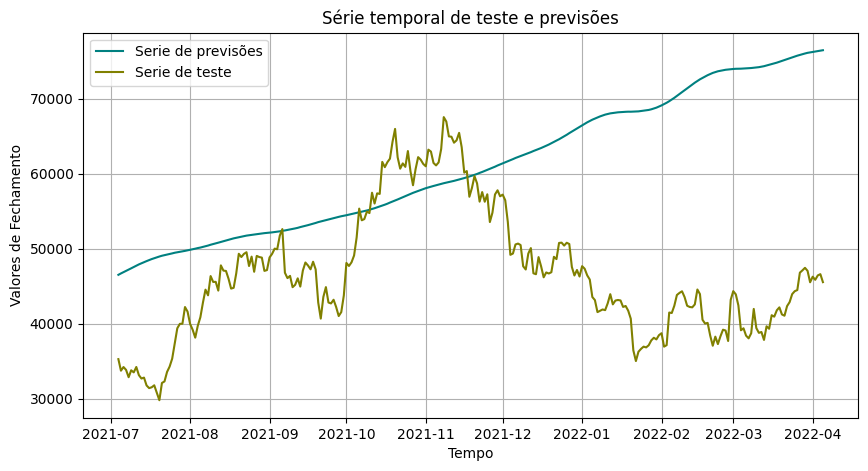

In [103]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de teste e previsões')
plt.plot(df_prev_prophet['yhat'].tail(len(test_y)), color='teal', label='Serie de previsões')
plt.plot(test_y, color='olive', label='Serie de teste')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Aproximando o gráfico do período de teste, notamos que a maioria dos dados se perde até do intervalo de confiança previsto.

In [104]:
previsoes_prophet = df_prev_prophet['yhat'].tail(len(test_y))

Agora pegamos somente os valores previstos referente a base de teste.

##### Métricas de erro

In [105]:
print(f'MAE: {mean_absolute_error(test_y, previsoes_prophet):.5f}')
print(f'RMSE: {mean_squared_error(test_y, previsoes_prophet, squared=False):.5f}')
print(f'R2_SCORE: {r2_score(test_y, previsoes_prophet):.5f}')

MAE: 15730.46135
RMSE: 19558.42043
R2_SCORE: -4.31016


Percebemos que os valores para as métricas de erro estão até maiores do que os valores encontrados no modelo auto_arima, indicando o pior desempenho até agora.

#### Modelo LSTM

##### Preparação dos dados

In [106]:
days_train = 15

Estabelecemos a quantidade de dias que serão utilizados como treinamento

In [107]:
treino_LSTM, test_LSTM = np.array(y[0:treino_linhas]), np.array(y[treino_linhas - days_train:])
treino_LSTM.shape, test_LSTM.shape

((2482,), (291,))

Agora criamos dois arrays, onde o primeiro ira pegar todos os valores da base de treinamento, já o segundo ira pegar todos os valores da base de teste mais os últimos quinze dias da base de treinamento

In [108]:
data_treino = treino_LSTM.reshape(-1,1)
data_test = test_LSTM.reshape(-1,1)

data_treino.shape, data_test.shape

((2482, 1), (291, 1))

Acima efetuamos um redimensionamento dos arrays

In [109]:
# Normalizando os Dados

# y treino
scaler = MinMaxScaler(feature_range=(0,1))
data_treino_scaler = scaler.fit_transform(data_treino)

# y teste
data_test_scaler = scaler.transform(data_test)

# Resultado treino
print('Dados de treino: ')
print(data_treino_scaler[:5])
print(f'Tamanho dos dados de treino: {len(data_treino_scaler)}')
print('')
# Resultado teste
print('Dados de teste: ')
print(data_test_scaler[:5])
print(f'Tamanho dos dados de teste: {len(data_test_scaler)}')

Dados de treino: 
[[0.00440947]
 [0.00389002]
 [0.0034219 ]
 [0.00364469]
 [0.00348546]]
Tamanho dos dados de treino: 2482

Dados de teste: 
[[0.55961421]
 [0.56091584]
 [0.49740883]
 [0.51049943]
 [0.52972344]]
Tamanho dos dados de teste: 291


Efetuamos aqui uma normalização dos dados para que seus valores fiquem entre 0 e 1, evitando assim que tenhamos valores muito maiores do que os outros

In [110]:
# Treino
x_trainlstm, y_trainlstm = [],[]
for i in range(days_train, len(data_treino)):
  x_trainlstm.append(data_treino_scaler[i - days_train:i])
  y_trainlstm.append(data_treino_scaler[i])

# Teste
x_testlstm, y_testlstm = [], []
for c in range(days_train, len(data_test)):
  x_testlstm.append(data_test_scaler[c - days_train:c])
  y_testlstm.append(data_test_scaler[c])

# Convertendo para matriz
LSTM_x_train = np.array(x_trainlstm)
LSTM_y_train = np.array(y_trainlstm)
LSTM_x_test = np.array(x_testlstm)
LSTM_y_test = np.array(y_testlstm)

LSTM_x_train.shape, LSTM_y_train.shape, LSTM_x_test.shape, LSTM_y_test.shape

((2467, 15, 1), (2467, 1), (276, 15, 1), (276, 1))

Aqui criamos 4 arrays, onde que para a base de treinamento teremos dois arrays sendo que o primeiro irá guardar os últimos quinze dias para cada valor da base de treino (2467, 15, 1) por isso a estrutura de 2467 linhas onde cada linha possuirá um array de 15 valores sendo dispostos em uma coluna, os quinze primeiros valores da base de treino serão utilizados somente como treinamento por isso a base de treino diminuiu de 2482 para 2467. No segundo array iremos guardar os valores de cada dia (2467, 1) sendo 2467 valores em uma coluna.

Já nos dois arrays da base de teste, tivemos o cuidado de reservar quinze dias a mais antes do início da base de teste, para que cada valor da base de teste possuísse um array com os últimos quinze dias.

##### Modelo

In [111]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences=True, input_shape = (LSTM_x_train.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

regressor.fit(LSTM_x_train, LSTM_y_train, epochs = 100, batch_size = 32)

Epoch 1/100
78/78 [==============================] - 7s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0407
Epoch 2/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0305
Epoch 3/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0280
Epoch 4/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0021 - mean_absolute_error: 0.0279
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0022 - mean_absolute_error: 0.0266
Epoch 6/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0254
Epoch 7/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0019 - mean_absolute_error: 0.0258
Epoch 8/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0021 - mean_absolute_error: 0.0254
Epoch 9/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0245
Epo

Para esta nossa previsão utilizamos LSTM, pois conforme estudos o mesmo possui bons resultados em relação a previsões de séries temporais.

Os parâmetros para este modelo foram escolhidos de forma empírica, utilizando como base o conhecimento das características da base de dados.

Na primeira camada para o parâmetro do "units" utilizamos o valor de cem, pois ele equivale ao número de células de memória, ele tem que ser um valor grande, pois o mesmo irá capturar a tendência e adicionar mais dimensionalidade no decorrer do tempo. No segundo parâmetro o "return_sequences" ele precisara receber o valor de verdadeiro, pois ele irá passar a informação para as camadas subsequentes e para o "input_shape" iremos passar a estrutura dos dados. Ainda na primeira camada passamos um "Dropout" onde o mesmo ira zerar trinta por cento das entradas prevenindo o overfitting.

Nas próximas três camadas, para o parâmetro de "units" utilizaremos a metade das células de memória da primeira camada, iremos passar o "return_sequences" como verdadeiro se possuirmos uma próxima camada para receber os dados e também iremos adicionar um "Dropout" para prevenir o overfitting.

Após as camadas acima, irei adicionar uma camada densa onde a mesma irá retornar a resultado do neurônio. Para o parâmetro "units" iremos passar o valor de um, pois o ele retornará o um valor previsto de saída e como estamos trabalhando com uma regressão vamos utilizar a função de ativação "linear", pois a mesma irá somente passar o valor não tendo nenhum Ação que irá influenciar no resultado.

Após iremos executar a função "compile" onde conforme documentação da biblioteca "Keras" para o primeiro parâmetro vamos utilizar a função "rmsprop", pois ela é uma boa opção para rede neurais recorrentes, para a "loss" vamos utilizar o erro médio quadrático e para o "metrics" e métrica de erro médio absoluto.

E para a função de treinamento iremos passar os dados de treino, passamos cem épocas, sendo este um valor mínimo para termos resultados bons e o "batch_size" vai receber o valor de 32, pois ele se trata do número de exemplos de treinamento usados em uma iteração.

Podemos perceber que ao longo das épocas a medida que o treinamento ocorre a função de perda vai diminuindo e em paralelo o erro médio absoluto também.




In [112]:
predict = regressor.predict(LSTM_x_test)

9/9 [==============================] - 1s 4ms/step


Efetuamos a previsão dos valores com o modelo treinado

In [113]:
predict_LSTM = scaler.inverse_transform(predict)

Revertemos a normalização dos valores previstos

In [114]:
future_LSTM = pd.DataFrame(predict_LSTM, index=test_y.index, columns=['Prediction_LSTM'])
future_LSTM.head()

,Prediction_LSTM
Date,
2021-07-04,33535.847656
2021-07-05,33599.710938
2021-07-06,33601.675781
2021-07-07,33531.597656
2021-07-08,33418.535156


Agora inserimos a indexação da data da base de teste e transformamos os valores previstos em um dataframe

In [115]:
treino_y = y.head(treino_linhas)

test_y = y[treino_linhas:]

treino_y.tail()

Date
2021-06-29    35867.777344
2021-06-30    35040.835938
2021-07-01    33572.117188
2021-07-02    33897.046875
2021-07-03    34668.546875
Name: Close, dtype: float64

In [116]:
test_y.head()

Date
2021-07-04    35287.781250
2021-07-05    33746.003906
2021-07-06    34235.195313
2021-07-07    33855.328125
2021-07-08    32877.371094
Name: Close, dtype: float64

Pegamos os dados não normalizados tanto de da base de treinamento quanto da base de teste

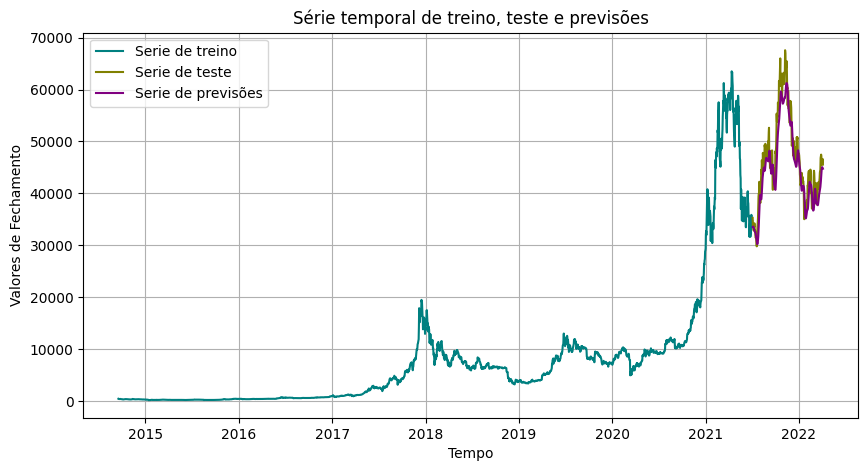

In [117]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de treino, teste e previsões')
plt.plot(treino_y, color='teal', label='Serie de treino')
plt.plot(test_y, color='olive', label='Serie de teste')
plt.plot(future_LSTM['Prediction_LSTM'], color='purple', label='Serie de previsões')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Podemos notar graficamente que este foi o modelo com o melhor desempenho, pois mesmo com o pico de valores no ano de 2020 o ele conseguiu bons resultados.

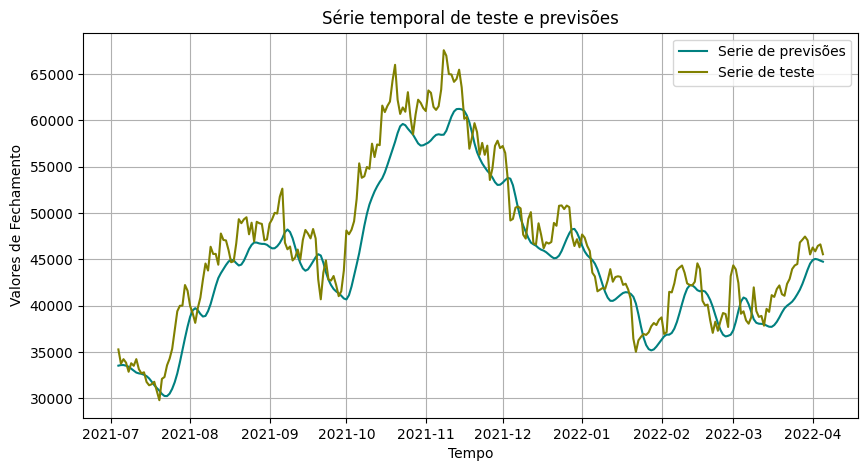

In [118]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de teste e previsões')
plt.plot(future_LSTM['Prediction_LSTM'], color='teal', label='Serie de previsões')
plt.plot(test_y, color='olive', label='Serie de teste')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Com uma visão mais aproximada dos valores previstos junto a base de teste, inferimos que os valores quase se assemelham conseguindo capturar a tendência dos valores da base de teste

In [119]:
previsoes_LSTM = future_LSTM['Prediction_LSTM']

Agora contraímos somente os valores previstos

##### Métricas de erro

In [120]:
print(f'MAE: {mean_absolute_error(test_y, previsoes_LSTM):.5f}')
print(f'RMSE: {mean_squared_error(test_y, previsoes_LSTM, squared=False):.5f}')
print(f'R2_SCORE: {r2_score(test_y, previsoes_LSTM):.5f}')

MAE: 2649.14694
RMSE: 3315.57010
R2_SCORE: 0.84740


Somos capazes notar que este foi o modelo com menores valores de perda nas métricas utilizadas, sendo este o modelo que iremos seguir para a etapa de validação dos dados.

#### Validação para Séries Temporais

Para a validação iremos utilizar um método de validação cruzada para séries temporais.

In [121]:
val_scaler = np.array(y)
val_scaler = val_scaler.reshape(-1,1)
val_scaler = scaler.fit_transform(val_scaler)

In [122]:
val_scaler.shape

(2758, 1)

Executamos uma captação dos valores de fechamento da nossa divisão inicial da base de dados de treinamento e teste ainda juntos, menos os últimos trinta dias da validação, então efetuamos um redimensionamento dos dados e uma normalização dos dados.

In [123]:
var = len(val_scaler) // 10
var

275

Aqui efetuamos uma divisão da base de dados em dez blocos, onde cada bloco terá uma parte para treinamento e outra para teste. Então a cada período de 275 dias validaremos o nível de evolução do modelo.

In [124]:
n = 0
cv_loss, cv_accuracy = [], []
for i in range(var,len(val_scaler), var):
  train, test = train_test_split(val_scaler[n:i], test_size = 0.27, random_state = 0)
  n = i
  train = train.reshape(-1,1)
  test = test.reshape(-1,1)

  #Treino
  X_train, y_train = [],[]
  for j in range(days_train, len(train)):
    X_train.append(train[j - days_train:j])
    y_train.append(train[j])

  # Teste
  X_test, y_test = [], []
  for c in range(days_train, len(test)):
    X_test.append(test[c - days_train:c])
    y_test.append(test[c])

  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  regressor.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0, shuffle=False)

  score = regressor.evaluate(X_test, y_test, verbose=0)
  cv_loss.append(score[0])
  cv_accuracy.append(score[1])
  print(f'{regressor.metrics_names[0]}: {score[0]:.7f} {regressor.metrics_names[1]}: {score[1]:.7f}')
print(f'Total da média do {regressor.metrics_names[0]}: {np.mean(cv_loss):.7f}')
print(f'Total da média do {regressor.metrics_names[1]}: {np.mean(cv_accuracy):.7f}')


loss: 0.0000028 mean_absolute_error: 0.0014083
loss: 0.0000209 mean_absolute_error: 0.0044198
loss: 0.0000068 mean_absolute_error: 0.0021723
loss: 0.0002680 mean_absolute_error: 0.0133088
loss: 0.0024154 mean_absolute_error: 0.0379213
loss: 0.0004235 mean_absolute_error: 0.0198215
loss: 0.0009261 mean_absolute_error: 0.0242460
loss: 0.0004289 mean_absolute_error: 0.0157133
loss: 0.0609208 mean_absolute_error: 0.2123553
loss: 0.0183968 mean_absolute_error: 0.1088261
Total da média do loss: 0.0083810
Total da média do mean_absolute_error: 0.0440193


Como podemos perceber o modelo se adapta muito bem aos períodos iniciais, onde não tivemos quase variação dos valores. Já para o final percebemos que a sua taxa de perda e sua média de erro estão mais altas do que os intervalos de tempo do início.

Podemos concluir que o modelo não se adapta tão bem as grandes variações, pois inicialmente não teve contato com esta oscilação de valores, podendo o mesmo se adaptar melhor a dados que possuam uma certa sazonalidade ou tendencia continua.

Sendo que sua média total se manteve baixa por causa das primeiras leituras do modelo.

#### Validação do Algoritmo

Agora iremos testar o modelo em uma previsão de trinta dias, onde o modelo não teve nenhum contato inicial, simulando assim a previsão para a quantidade de dias alvo.

##### Preparação dos dados

In [125]:
print(f'Dados: {validation[0]}\nTamanho: {len(validation)}')

Dados: 43206.738281
Tamanho: 30


Acima selecionamos os últimos trinta dias da base de dados, que já foram separados durante a fase de preparação dos dados para usar como base de teste.

In [126]:
linha = treino_linhas + len(test_y)
linha

2758

Agora unimos a quantidade total de linhas utilizadas para a base de treino e teste, onde iremos utilizar estes dados para treinamento do modelo. 

In [127]:
x_vallstm, y_vallstm = [],[]
for i in range(days_train, len(val_scaler)):
  x_vallstm.append(val_scaler[i - days_train:i])
  y_vallstm.append(val_scaler[i])

X_LSTM_val = np.array(x_vallstm)
y_LSTM_val = np.array(y_vallstm)
X_LSTM_val.shape, y_LSTM_val.shape

((2743, 15, 1), (2743, 1))

Aqui redimensionamos e normalizamos os dados no mesmo modo que foi anteriormente trabalhado, ficando com quinze dias anteriores ao dia de previsão como treino e o dia de previsão como valor previsto.

In [128]:
validation_LSTM = np.array(target[linha - days_train:])
validation_LSTM = validation_LSTM.reshape(-1,1)
val_scaler = scaler.transform(validation_LSTM)

x_validationlstm, y_validationlstm = [], []
for c in range(days_train, len(validation_LSTM)):
  x_validationlstm.append(data_test_scaler[c - days_train:c])
  y_validationlstm.append(data_test_scaler[c])

LSTM_x_validation = np.array(x_validationlstm)
LSTM_y_validation = np.array(y_validationlstm)

LSTM_x_validation.shape, LSTM_y_validation.shape

((30, 15, 1), (30, 1))

Para a base de dados de trinta dias, executamos o mesmo procedimento.

In [129]:
regressor.fit(X_LSTM_val, y_LSTM_val, epochs = 100, batch_size = 32)

Epoch 1/100
86/86 [==============================] - 1s 13ms/step - loss: 0.0215 - mean_absolute_error: 0.0942
Epoch 2/100
86/86 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0380
Epoch 3/100
86/86 [==============================] - 1s 11ms/step - loss: 0.0023 - mean_absolute_error: 0.0350
Epoch 4/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0330
Epoch 5/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0305
Epoch 6/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0296
Epoch 7/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0285
Epoch 8/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0279
Epoch 9/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0271
Epoch 1

In [130]:
predict_val = regressor.predict(LSTM_x_validation)

1/1 [==============================] - 0s 25ms/step


In [131]:
predict_validation = scaler.inverse_transform(predict_val)

future_validation = pd.DataFrame(predict_validation, index=validation.index, columns=['Prediction_validation'])
len(future_validation)

30

Após treinarmos o modelo e executarmos a previsão, pegamos a indexação temporal da base de validação de trinta dias e anexamos aos dados previstos para comparação em um gráfico. 
Conferimos também a quantidade de dias previstos.

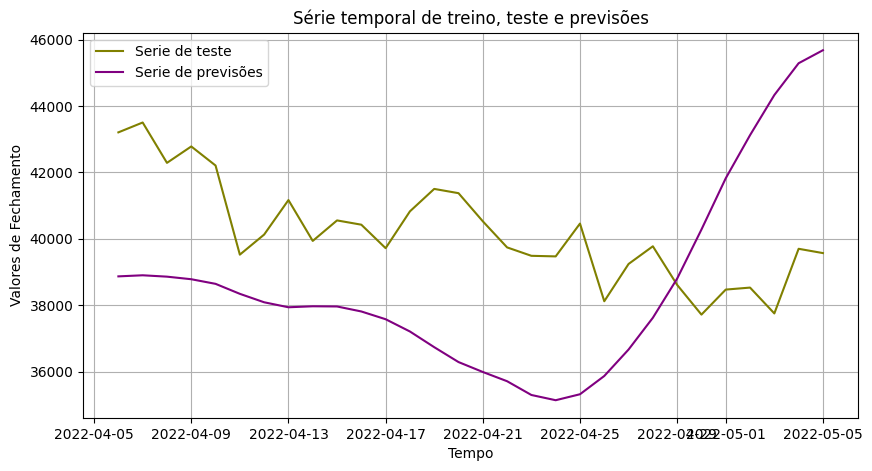

In [132]:
plt.figure(figsize=(10,5))
plt.title('Série temporal de treino, teste e previsões')
plt.plot(validation, color='olive', label='Serie de teste')
plt.plot(future_validation['Prediction_validation'], color='purple', label='Serie de previsões')
plt.xlabel('Tempo')
plt.ylabel('Valores de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Podemos notar que em dados onde o modelo não teve um contato anterior, o mesmo teve uma erta dificuldade para acompanhar os dados reais no principio.

Mas após vinte dias percebemos uma tentativa de correção dos valores previsto, onde a linha de previsão chega a cruzar a linha dos valores reais, mas continua sua subida suavizando ao final.

Quem sabe se o modelo possuisse um intervalo maior de dias para a previsão, como sessenta ou noventa dias acabasse interpretando melhor a tendencia e conseguindo chegar mais perto dos valores reais previstos. 

Neste contexto, podemos concluir que para um período curto de dias o modelo não teria um comportamento razoavel conforme foi esperado para príodos mais longos, mas com um período maior de dias pudéssemos ter ao final um desempenho melhor, conseguindo quase igualar aos valores reais.

In [133]:
previsoes_validation = future_validation['Prediction_validation']

In [134]:
print(f'MAE: {mean_absolute_error(validation, previsoes_validation):.5f}')
print(f'RMSE: {mean_squared_error(validation, previsoes_validation, squared=False):.5f}')
print(f'R2_SCORE: {r2_score(validation, previsoes_validation):.5f}')

MAE: 3580.09635
RMSE: 3861.05006
R2_SCORE: -5.54189


Conforme verificado, apesar do desempenho inferior ao esperado, o modelo se mostra ainda assim melhor do que os outros em uma base de dados onde o mesmo não teve nenhum contato prévio.